# Glasgow Restaurants' Reviews from Google Maps API and Tripadvisor API

## 1. Data Retrieval Strategy

In [1]:
import requests
import csv
import json
import time
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuanqinrun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuanqinrun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1.1 Google Maps API

In [2]:
def search_places(api_key, location, query, next_page_token=None):

    endpoint_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
    places = []
    params = {
        'query': query + ' in ' + location,
        'key': api_key
    }
    if next_page_token:
        params['pagetoken'] = next_page_token
        time.sleep(2)
    
    res = requests.get(endpoint_url, params=params)
    results = json.loads(res.content)
    if results['results']:
        for place in results['results']:
            places.append({
                'place_id': place['place_id'],
                'name': place['name']
            })
    next_page_token = results.get('next_page_token')
    return places, next_page_token

In [3]:
def get_reviews(api_key, place):

    endpoint_url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        'place_id': place['place_id'],
        'fields': 'reviews',
        'key': api_key
    }
    res = requests.get(endpoint_url, params=params)
    results = json.loads(res.content)
    reviews = []
    if 'reviews' in results.get('result', {}):
        for review in results['result']['reviews']:
            reviews.append({
                'name': place['name'],
                'rating': review['rating'],
                'text': review['text'] 
            })
    return reviews

In [4]:
def save_reviews_to_csv(reviews, filename):

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['name', 'rating', 'text']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for review in reviews:
            writer.writerow(review)

In [5]:
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

api_key_path = 'api_key_googlemap.txt'

API_KEY = read_api_key(api_key_path)
LOCATION = 'Glasgow'
QUERY = 'restaurants'

all_reviews = []
next_page_token = None

while len(all_reviews) < 1000:
    places, next_page_token = search_places(API_KEY, LOCATION, QUERY, next_page_token)
    for place in places:
        reviews = get_reviews(API_KEY, place)
        all_reviews.extend(reviews)
        if len(all_reviews) >= 1000:
            break
    if not next_page_token or len(all_reviews) >= 1000:
        break

save_reviews_to_csv(all_reviews, 'review.csv')
# it should be: save_reviews_to_csv(all_reviews, 'review's'.csv')
# just make sure that the final version is the same one

### 1.2 Tripadvisor API

In [6]:
def create_api_url(base_url, search_query, category, language):
    key = read_api_key("api_key_tripadvisor.txt")
    return f"{base_url}?key={key}&searchQuery={search_query}&category={category}&language={language}"

base_url = "https://api.content.tripadvisor.com/api/v1/location/search"
search_query = "Glasgow"
category = "restaurants"
language = "en"
url = create_api_url(base_url, search_query, category, language)

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

print(response.text)

{
  "data": [
    {
      "location_id": "4071805",
      "name": "Mini Grill Glasgow Steakhouse",
      "address_obj": {
        "street1": "244 Bath Street",
        "city": "Glasgow",
        "country": "United Kingdom",
        "postalcode": "G2 4JW",
        "address_string": "244 Bath Street, Glasgow G2 4JW Scotland"
      }
    },
    {
      "location_id": "770333",
      "name": "New Glasgow Lobster Supper",
      "address_obj": {
        "street1": "604 Rte 258",
        "city": "New Glasgow",
        "state": "Prince Edward Island",
        "country": "Canada",
        "postalcode": "C0A 1N0",
        "address_string": "604 Rte 258, New Glasgow, Prince Edward Island C0A 1N0 Canada"
      }
    },
    {
      "location_id": "2417300",
      "name": "Glasgow's Bar",
      "address_obj": {
        "street1": "Northside Road",
        "city": "Parlatuvier",
        "state": "Tobago",
        "country": "Trinidad and Tobago",
        "address_string": "Northside Road, Parlatuvier

In [7]:
data = json.loads(response.text)

location_url = "https://api.content.tripadvisor.com/api/v1/location"

headers = {"accept": "application/json"}

API_key = read_api_key('api_key_tripadvisor.txt')

all_reviews = []

for restaurant in data['data']:
    location_id = restaurant['location_id']

    review_url = f"{location_url}/{location_id}/reviews?key={API_key}&language=en"

    response = requests.get(review_url, headers=headers)
    reviews_data = json.loads(response.text)

    if 'data' in reviews_data:
        for review in reviews_data['data']:
            all_reviews.append(review['text'])

    print(f"Reviews for {restaurant['name']}:")
    print(response.text)
    print('---')

with open('trip_review.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['text'])
    for review_text in all_reviews:
        writer.writerow([review_text])
        
# it should be: trip_review's'.csv
# just make sure that the final version is the same one

Reviews for Mini Grill Glasgow Steakhouse:
{
  "data": [
    {
      "id": 947567790,
      "lang": "en",
      "location_id": 4071805,
      "published_date": "2024-04-20T10:37:50Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d4071805-r947567790-Reviews-Mini_Grill_Glasgow_Steakhouse-Glasgow_Scotland.html?m=66827#review947567790",
      "text": "Amazing food and friendly staff. Special thanks though to Tricia who made us feel most welcome. We will definitely be returning.",
      "title": "Amazing food and staff",
      "trip_type": "Couples",
      "travel_date": "2024-04-30",
      "user": {
        "username": "theresebG5785PN",
        "user_location": {
          "id": "null"
        },
        "avatar": {
          "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/1a/f6/e2/11/default-avatar-2020-41

Reviews for New Glasgow Lobster Supper:
{
  "data": [
    {
      "id": 932392796,
      "lang": "en",
      "location_id": 770333,
      "published_date": "2024-01-05T10:27:58Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g1800168-d770333-r932392796-Reviews-New_Glasgow_Lobster_Supper-New_Glasgow_Prince_Edward_Island.html?m=66827#review932392796",
      "text": "Absolutely fabulous meal! Do it! The lobster was big and buttery delicious. It was a wonderful experience! ",
      "title": "Awesome!",
      "trip_type": "Family",
      "travel_date": "2023-08-31",
      "user": {
        "username": "susand2013",
        "user_location": {
          "id": "940812",
          "name": "Bonfield, Northeastern Ontario, Ontario"
        },
        "avatar": {
          "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/1a/

Reviews for Glasgow's Bar:
{
  "data": [
    {
      "id": 919583196,
      "lang": "en",
      "location_id": 2417300,
      "published_date": "2023-10-03T06:47:03Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g1939760-d2417300-r919583196-Reviews-Glasgow_s_Bar-Parlatuvier_Tobago_Trinidad_and_Tobago.html?m=66827#review919583196",
      "text": "This is a must place to visit\nLooks nothing from the road , but a warm welcome awaits...grab your drink and go to the terraces, and the roof terrace, you will not be disappointed ( will not ruin but the view sells this place) \nSa hi to the parrots for me and put your feet up and chill Tobagan style",
      "title": "This is a mustplace when on the Island",
      "trip_type": "Couples",
      "travel_date": "2023-09-30",
      "user": {
        "username": "GaryS611",
        "user_

Reviews for Piccolo Mondo Glasgow:
{
  "data": [
    {
      "id": 947754392,
      "lang": "en",
      "location_id": 733732,
      "published_date": "2024-04-21T17:19:21Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d733732-r947754392-Reviews-Piccolo_Mondo_Glasgow-Glasgow_Scotland.html?m=66827#review947754392",
      "text": "Another visit to our favourite restaurant. Menu has changed since our last visit but staff accommodated and let us order items no longer on the menu.’can never fault the food or the staff always a pleasure and look forward to our next dinner there.",
      "title": "Lovely food and fabulous staff",
      "trip_type": "Couples",
      "travel_date": "2024-04-30",
      "user": {
        "username": "ss042",
        "user_location": {
          "id": "186534",
          "name": "Glasgow, Scotla

Reviews for Ka Pao Glasgow:
{
  "data": [
    {
      "id": 947358874,
      "lang": "en",
      "location_id": 15121260,
      "published_date": "2024-04-18T15:45:31Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d15121260-r947358874-Reviews-Ka_Pao_Glasgow-Glasgow_Scotland.html?m=66827#review947358874",
      "text": "Been to Ka Pao a few times but not for at least 18 months maybe longer. We booked for the Glasgow restaurant week set menu with great anticipation and loved every dish. Everything was so full of labour, fresh and great portions. Delicious. Service was great. Tried a cocktail which also got top marks. Can't fault a thing. Will hopefully be back soon 10/10",
      "title": "Perfect",
      "trip_type": "Couples",
      "travel_date": "2024-04-30",
      "user": {
        "username": "Z3338PBclaireg",
   

Reviews for Ikea Glasgow:
{
  "data": [
    {
      "id": 938504060,
      "lang": "en",
      "location_id": 7252323,
      "published_date": "2024-02-16T09:43:05Z",
      "rating": 1,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d7252323-r938504060-Reviews-Ikea_Glasgow-Glasgow_Scotland.html?m=66827#review938504060",
      "text": "The delivery team were friendly. However, I ordered multiple items and one of them was not delivered. I was not emailed to make me aware of this. I paid £25 for my items to be delivered today, and this was not carried out. It wasn’t delivered due to it being out of stock. This is not the delivery teams fault, it is ikeas. I am extremely disappointed and dissatisfied.",
      "title": "Paid for delivery, missed half my order",
      "trip_type": "Solo travel",
      "travel_date": "2024-02-29",
      "user": 

Reviews for TGI Fridays - Glasgow Fort:
{
  "data": [
    {
      "id": 945861202,
      "lang": "en",
      "location_id": 5439804,
      "published_date": "2024-04-08T13:12:36Z",
      "rating": 1,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d5439804-r945861202-Reviews-TGI_Fridays_Glasgow_Fort-Glasgow_Scotland.html?m=66827#review945861202",
      "text": "I am still in shock with the level of service, or should I say the lack of service\n\n3.30 on a Monday afternoon, not busy at all there must have been 10 staff members on the floor but despite this the service was appaling \n\n15 min wait to order drinks, and then another 20 mins after finishing our meal before plates were cleared, I had to ask for the bill, even table opposite us were complaining as they hadn't been served and another 15 min had passed \n\nIn a time when businesses

Reviews for Bar + Block Steakhouse Glasgow:
{
  "data": [
    {
      "id": 948686971,
      "lang": "en",
      "location_id": 23417093,
      "published_date": "2024-04-28T16:05:33Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d23417093-r948686971-Reviews-Bar_Block_Steakhouse_Glasgow-Glasgow_Scotland.html?m=66827#review948686971",
      "text": "This is a fantastic place for a night out, attentive staff and incredible food! \n\nWaheed was our server, awesome guy \n\nSteaks are next level.",
      "title": "Waheed FTW!",
      "trip_type": "Couples",
      "travel_date": "2024-04-30",
      "user": {
        "username": "jamiebI7960TX",
        "user_location": {
          "id": "null"
        },
        "avatar": {
          "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/1a/f6/e2/a7/default-avatar-2

Reviews for Curry Cottage Glasgow:
{
  "data": [
    {
      "id": 945680179,
      "lang": "en",
      "location_id": 23683995,
      "published_date": "2024-04-07T07:11:52Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d23683995-r945680179-Reviews-Curry_Cottage_Glasgow-Glasgow_Scotland.html?m=66827#review945680179",
      "text": "So we visit Glasgow regularly every 6 weeks from Liverpool, and we always try and find new places to eat when we visit. The curry cottage was this visit hit.\nSitting just one or 2 minutes from Sauchiehall Street, what I think may be Glasgows china town district, sat this little family run restaurant. Small menu, but all the choices you would need from Karahi to tikas to Naga.\nWe had chicken pepper pakoras and hagis pakoras which were dee lish followed by Keema Aloo which is lamb mince p

Reviews for Saint Judes Glasgow:
{
  "data": [
    {
      "id": 945813932,
      "lang": "en",
      "location_id": 8726994,
      "published_date": "2024-04-08T06:37:15Z",
      "rating": 5,
      "helpful_votes": 0,
      "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s5.0-66827-5.svg",
      "url": "https://www.tripadvisor.com/ShowUserReviews-g186534-d8726994-r945813932-Reviews-Saint_Judes_Glasgow-Glasgow_Scotland.html?m=66827#review945813932",
      "text": "Great lunch & cocktails at Saint Jude’s, staff were so attentive and friendly from the moment we walked in. Will definitely be back.",
      "title": "Great Lunch / Amazing cocktails!!",
      "trip_type": "Couples",
      "travel_date": "2024-04-30",
      "user": {
        "username": "bcD6694GN",
        "user_location": {
          "id": "null"
        },
        "avatar": {
          "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/1a/f6/e2/81/default-avatar-2020-43.jpg",
    

In [8]:
# csv_files = ['reviews.csv', 'reviews_1.csv', 'reviews_2.csv', 'reviews_3.csv', 'reviews_4.csv', 'trip_reviews.csv']

# json_file = 'reviews_5.json'


# df_csv = pd.concat([pd.read_csv(file, usecols=['text'], encoding='utf-8') for file in csv_files])


# df_json = pd.read_json(json_file)

# df_json = df_json[['text']]

# df_merged = pd.concat([df_csv, df_json])

# df_unique = df_merged.drop_duplicates()

# print(df_unique)

# df_unique.to_csv('r_reviews.csv', index=False, encoding='utf-8')

                                                  text
0    My husband and I were wowed by our experience ...
1    A great find thanks to the Michelin Guide, whe...
2    We discovered this wonderful restaurant today....
3    Yesterday I had a professional dinner at this ...
4    Out for our anniversary dinner..\nWe both agre...
..                                                 ...
265  Service was excellent and the chef came out to...
266  Lovely food and friendly service. Bargain lunc...
267  We came in on the off chance of grabbing a tab...
268  Staff were nice, starters were good, the lasag...
269  The food is really nice, but the waiter and ow...

[696 rows x 1 columns]


## 2. Natural Language Processing

### 2.1 Procedures

In [9]:
with open('r_reviews.csv', 'r', encoding='utf-8') as reviews_read:
    reviews_string = reviews_read.read()
reviews_string

'text\n"My husband and I were wowed by our experience at number 16. It was our last meal of our honeymoon, and we wanted a really good dinner. I cannot say enough about this restaurant. The food was exquisite. Everything from the soup to the entrees, to the incredible lemon dessert thing! The service was excellent too! I wish I could remember our servers name. He was super tall with reddish hair. 20 some thing.\n\nI think one of the best references we can give is that we were sitting next to a party who were locals. Will locals as in three hours from the restaurant. They said that they never miss coming to the restaurant every time they’re in town. The next time we are in Glasgow, we will definitely make it back!"\n"A great find thanks to the Michelin Guide, where Number 16 very much deserves to be. Lovely little place with very friendly staff, really delicious food (the cured sea bass to start was absolutely exceptional). Really glad to have found this place: highly recommend."\n"We d

In [10]:
reviews_split = reviews_string.split('.')
reviews_split

['text\n"My husband and I were wowed by our experience at number 16',
 ' It was our last meal of our honeymoon, and we wanted a really good dinner',
 ' I cannot say enough about this restaurant',
 ' The food was exquisite',
 ' Everything from the soup to the entrees, to the incredible lemon dessert thing! The service was excellent too! I wish I could remember our servers name',
 ' He was super tall with reddish hair',
 ' 20 some thing',
 '\n\nI think one of the best references we can give is that we were sitting next to a party who were locals',
 ' Will locals as in three hours from the restaurant',
 ' They said that they never miss coming to the restaurant every time they’re in town',
 ' The next time we are in Glasgow, we will definitely make it back!"\n"A great find thanks to the Michelin Guide, where Number 16 very much deserves to be',
 ' Lovely little place with very friendly staff, really delicious food (the cured sea bass to start was absolutely exceptional)',
 ' Really glad to

In [11]:
STOPWORDS = ["an", "a", "the", "or", "and", "thou", "must", "that", "this", "self", "unless", "behind", "for", "which",
             "whose", "can", "else", "some", "will", "so", "from", "to", "by", "within", "of", "upon", "th", "with",
             "it"]

def _remove_stopwords(txt):
    words = txt.split()
    for i, word in enumerate(words):
        if word in STOPWORDS:
            words[i] = " "
    return " ".join(words).strip()

In [12]:
doc_out = []
for k in reviews_split:
    cleantextprep = str(k)
    expression = "[^a-zA-Z ]" 
    cleantextCAP = re.sub(expression, '', cleantextprep) 
    cleantext = cleantextCAP.lower()
    cleantext = _remove_stopwords(cleantext)
    doc_out.append(cleantext)

In [13]:
def decompose_word(doc):
    txt = []
    for word in doc:
        txt.extend(word.split())
    return txt

tokens = decompose_word(doc_out)
tagged_tokens = nltk.pos_tag(tokens)

pos_dict = {}
for word, pos in tagged_tokens:
    if pos in pos_dict:
        pos_dict[pos].append(word)
    else:
        pos_dict[pos] = [word]

for pos, words in pos_dict.items():
    print(f"{pos}: {', '.join(set(words))}")

JJ: overcooked, moregreat, placeold, im, glasgows, tikka, male, heaven, kimchi, moist, colourful, dishthe, disappeared, separatelyfirst, horseradish, dosa, allotted, girl, uber, overly, squeeze, buzz, joyful, lacking, second, sad, inside, limited, full, smoothie, ordinary, floury, prawns, sample, steep, superbits, add, charity, unknown, sheen, subterranean, happened, overdue, lamb, unidays, grill, eating, chill, pretty, lucia, youd, lebanese, louis, restaurantcafe, open, genuine, romantic, goodbut, liked, oh, shocked, layer, floral, easy, highlight, single, south, variety, ham, private, pub, tikas, ooomph, nervous, trendy, veggie, few, underdone, festive, itincredible, individual, steakhouse, drive, avocado, female, complete, total, dinner, mediterranean, january, gyu, venison, bolognese, candle, birthday, faith, sweetcorn, ill, dine, bold, nightstylish, narrow, disappointedif, creamy, cafe, crunchy, tendersreturned, disaster, creative, akin, perfectwe, courteous, polite, bossy, bad, i

### 2.2  Wordcloud

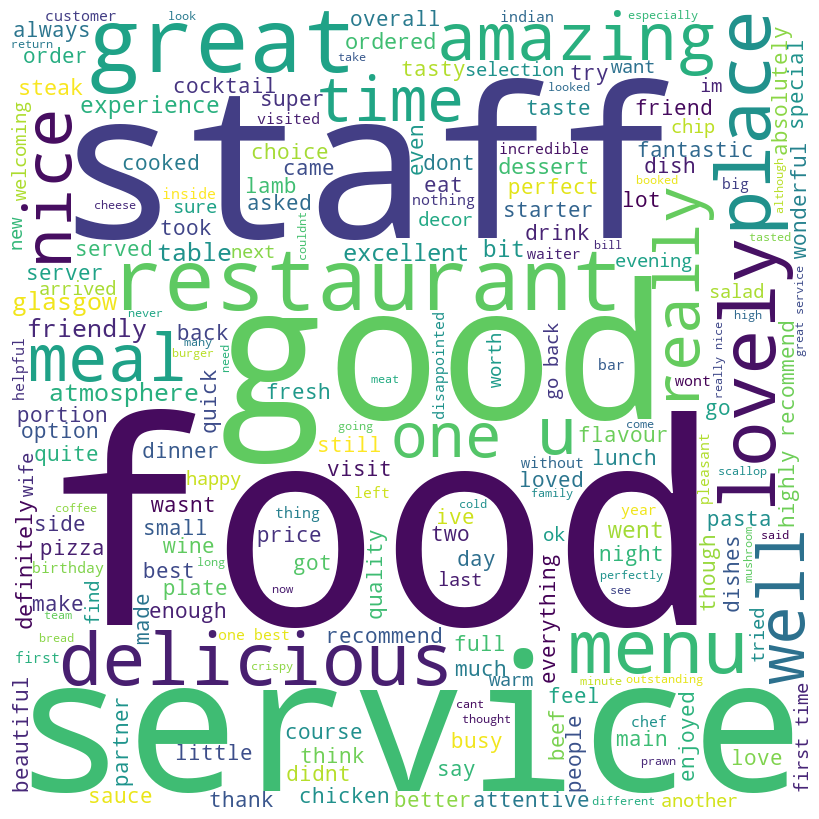

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
comment_words = ' '
for token in tokens:
    comment_words = comment_words + token + ' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
#min_font_size：minimum font size for words
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
#turn off axis display
plt.axis("off")
plt.tight_layout(pad=0)

plt.savefig("wordcloud.png", format='png', dpi=300)

plt.show()

## 3. Sentiment analysis

### 3.1 Sentiment and Textual Analysis

In [15]:
ndct = ''
with open('bl_negative.csv', 'r', encoding='utf-8', errors='ignore') as infile:
    for line in infile:
        ndct = ndct + line
# create a list of negative words
ndct = ndct.split('\n')
print(ndct)
len(ndct)    # 4783 negative words

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'absurdly', 'absurdness', 'abuse', 'abused', 'abuses', 'abusive', 'abysmal', 'abysmally', 'abyss', 'accidental', 'accost', 'accursed', 'accusation', 'accusations', 'accuse', 'accuses', 'accusing', 'accusingly', 'acerbate', 'acerbic', 'acerbically', 'ache', 'ached', 'aches', 'achey', 'aching', 'acrid', 'acridly', 'acridness', 'acrimonious', 'acrimoniously', 'acrimony', 'adamant', 'adamantly', 'addict', 'addicted', 'addicting', 'addicts', 'admonish', 'admonisher', 'admonishingly', 'admonishment', 'admonition', 'adulterate', 'adulterated', 'adulteration', 'adulterier', 'adversarial', 'adversary', 'adverse', 'adversity', 'afflict', 'affliction', 'afflictive', 'affront', 'afraid', 'aggravate', 'aggravating', 'aggravation', 'aggression', 'aggress

4783

In [16]:
pdct = ''
with open('bl_positive.csv', 'r', encoding='utf-8', errors='ignore') as infile:
    for line in infile:
        pdct = pdct + line

pdct = pdct.split('\n')
print(pdct)
len(pdct)  # 2009 positive words

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'ag

2009

In [17]:
from collections import Counter

def wordcount(text, lexicon):
    """Count the frequency of words from a given lexicon in the text."""
    # count the words that appear in the vocabulary and their frequency in the text
    word_freq = Counter(word for word in text if word in lexicon)
    # convert the results to a list and sort them by word
    return sorted(word_freq.items())


In [18]:
# list of negative words and their frequency
nwc = wordcount(tokens, ndct)   # wordcount(text,lexicon)

# list of positive words and their frequency
pwc = wordcount(tokens, pdct)

# Total number of positive/negative words
ntot, ptot = 0, 0
for i in range(len(nwc)):
    ntot += nwc[i][1]
for i in range(len(pwc)):
    ptot += pwc[i][1]
nwords = ntot+ptot

In [19]:
print('Positive words:')
for i in range(len(pwc)):
    print(str(pwc[i][0]) + ': ' + str(pwc[i][1]))
print('Total number of positive words: ' + str(ptot))
print('\n')
print('Percentage of positive words: ' + str(round(ptot / nwords, 4)))
print('\n')
print('Negative words:')
for i in range(len(nwc)):
    print(str(nwc[i][0]) + ': ' + str(nwc[i][1]))
print('Total number of negative words: ' + str(ntot))
print('\n')
print('Percentage of negative words: ' + str(round(ntot / nwords, 4)))

Positive words:
accurate: 2
adequate: 1
admire: 1
advantage: 2
adventurous: 1
affordable: 4
amazed: 1
amazing: 143
amazingly: 4
amenable: 1
ample: 2
appreciate: 2
appreciated: 6
assurance: 1
astounding: 1
astoundingly: 1
attentive: 85
authentic: 20
available: 10
award: 3
awarded: 1
awesome: 6
balanced: 5
bargain: 3
beautiful: 36
beautifully: 11
beauty: 1
benefit: 1
benefits: 1
best: 114
better: 33
bliss: 1
blossom: 2
bonus: 3
breeze: 1
bright: 2
brilliant: 17
brisk: 1
capable: 1
celebrate: 10
celebrated: 1
celebration: 1
charismatic: 1
charm: 2
charming: 2
cheaper: 3
cheapest: 1
cheery: 2
cherish: 1
chic: 3
classic: 4
classy: 2
clean: 21
cleanliness: 2
clear: 5
cleared: 4
clearly: 9
clever: 1
colorful: 1
comfort: 2
comfortable: 5
comforting: 2
compassion: 1
complemented: 3
complimentary: 6
confidence: 1
confident: 1
congratulate: 1
congratulations: 2
consistent: 1
consistently: 1
convenient: 2
cool: 6
correctly: 1
courteous: 3
cozy: 10
creative: 7
crisp: 4
cute: 9
decent: 15
delectable

### 3.2 Topic Modelling

In [20]:
import pandas as pd

# Load data
reviews_df = pd.read_csv('r_reviews.csv')

# Assuming some preprocessing to create 'cleaned_text' column
reviews_df['cleaned_text'] = reviews_df['text'].str.lower().str.replace('[^a-z ]', '')

/var/folders/1n/f58mw6t93fqg5b4p4dx80sz40000gn/T/ipykernel_13185/2481816621.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_df['cleaned_text'] = reviews_df['text'].str.lower().str.replace('[^a-z ]', '')


In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'cleaned_text' is prepared and exists in the dataframe
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(reviews_df['cleaned_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tfidf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [22]:
# Assuming LDA model has been applied previously and 'lda' variable exists
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_, start=1):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names(), 10)

Topic 1:
food good great service lovely staff time really place amazing
Topic 2:
food great lovely definitely restaurant staff service amazing really menu
Topic 3:
food staff delicious just service menu great amazing good meal
Topic 4:
food friendly service staff great lamb time atmosphere table fantastic
Topic 5:
good service food nice atmosphere really restaurant glasgow chicken best


/Users/yuanqinrun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
from sklearn.decomposition import NMF

# Apply NMF Model
nmf_model = NMF(n_components=5, random_state=0)
nmf_topics = nmf_model.fit_transform(tfidf)

# Display NMF Topics with topic indices starting from 1
def display_nmf_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_, start=1):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_nmf_topics(nmf_model, tfidf_vectorizer.get_feature_names(), 10)

Topic 1:
lovely staff delicious friendly food definitely attentive recommend absolutely helpful
Topic 2:
good really nice food service enjoyed atmosphere restaurant value excellent
Topic 3:
chicken ordered like dessert just got sauce table steak main
Topic 4:
great menu lunch dishes wine bit service try tasting time
Topic 5:
service amazing best food glasgow excellent ive restaurant perfect time


/Users/yuanqinrun/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/yuanqinrun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 3.3 Worldcloud

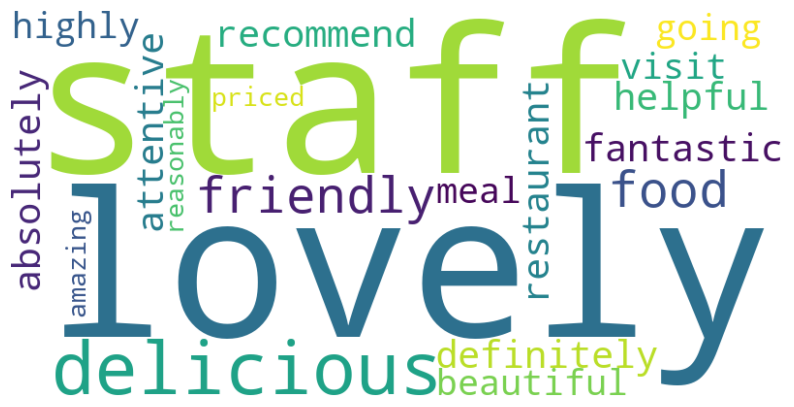

In [24]:
def plot_word_cloud(topic_idx):
    # Generate text for word cloud with spaces for clarity
    imp_words_topic = ' '.join([tfidf_vectorizer.get_feature_names()[i] for i in nmf_model.components_[topic_idx-1].argsort()[:-21:-1]])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(imp_words_topic)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_word_cloud(1)